In [18]:
import networkx as nx
# https://networkx.github.io/documentation/stable/reference/index.html
import matplotlib.pyplot as plt
from matplotlib import pylab
import numpy as np
import pandas as pd

In [19]:
# load the graph
# The graph is an extraction from LinkedIn Social Network
G = nx.read_gexf("mediumLinkedin.gexf")

# Exploration of the graph : relational data understanding

In [20]:
# networkx short summary of information for the graph g
print(G)

Graph with 811 nodes and 1597 edges


In [21]:
G.number_of_nodes()

811

In [22]:
G.number_of_edges()

1597

## Degree


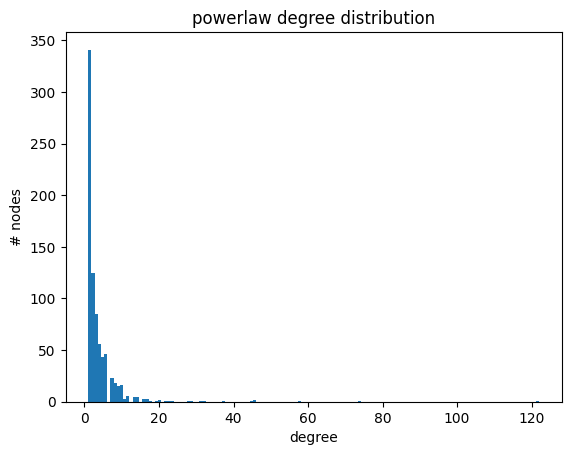

In [23]:
# Draw the degree distribution. If powerlow distribution, the graph shows one of the properties
# of a real (complex) network, such as social networks, biological networks, internet networks.
plt.figure(num=None)
fig = plt.figure(1)
degree_sequence=[d for n, d in G.degree()] # degree sequence
plt.hist(degree_sequence, bins='auto')
plt.title("powerlaw degree distribution")
plt.ylabel("# nodes")
plt.xlabel("degree")
plt.show()
pylab.close()
del fig

In [24]:
# To see the nodes with the highest degree
# We use "sorted" to sort a list
# We build the list of items (key + value) from NetworkX dictionary given by G.degree()
# The sort key is a lambda function which gives the indice of the data to sort.
# t is a tuple (key, value) from the dict
# Lambda says to sort with the value of the tuple: t[1], here the value form (key,value), i.e. d (the degree)
# to sort the tuple on the key, choose t[0]
sorted_nodes_by_degree=sorted([(n,d) for n, d in G.degree()], key=lambda t: t[1])
print("The 5 nodes with the highest degree are: %s" % str(sorted_nodes_by_degree[-5:]))
print("5 of the nodes with the smallest degree are: %s" % str(sorted_nodes_by_degree[:5]))

The 5 nodes with the highest degree are: [('U7972', 46), ('U8670', 46), ('U1045', 58), ('U7024', 74), ('U27287', 122)]
5 of the nodes with the smallest degree are: [('U8804', 1), ('U27759', 1), ('U7310', 1), ('U22859', 1), ('U1417', 1)]


## Neighbors

In [25]:
# To see the neighbors of a node
print("U7912 has %d neighbors" % len([n for n in G.neighbors('U7912')]))
print("U7912 has %d neighbors" % G.degree('U7912'))


U7912 has 17 neighbors
U7912 has 17 neighbors


In [26]:
for n in G.neighbors('U7912'):
    print(n)

U4456
U7909
U18928
U18965
U18942
U9126
U18939
U14577
U18949
U18932
U4488
U27941
U16219
U4485
U4661
U18914
U18943


# So, what about the influencers?

A first strategy could be to use the highest degree, but how, to do what? And how to measure their influence?

Be creative!

## Top 5 influencers by highest degree

In [27]:
# Filter for SF Bay Area
sf_area = "san francisco bay area"

Top 5 Influencers in SF Bay Area by Degree:
     name  degree                                            college  \
0   U8670      46  university of illinois at urbana-champaign, un...   
1  U15267      32  university of illinois at urbana-champaign, ba...   
2  U24045      24                                tsinghua university   
3   U4568      14                      shanghai jiao tong university   
4  U27661       9                      shanghai jiao tong university   

                                            employer  
0  akamai technologies, university of illinois at...  
1  university of illinois at urbana-champaign, ba...  
2    university of illinois at urbana-champaign, ibm  
3  google, university of illinois at urbana-champ...  
4  google, at&amp;t labs inc., university of mich...  


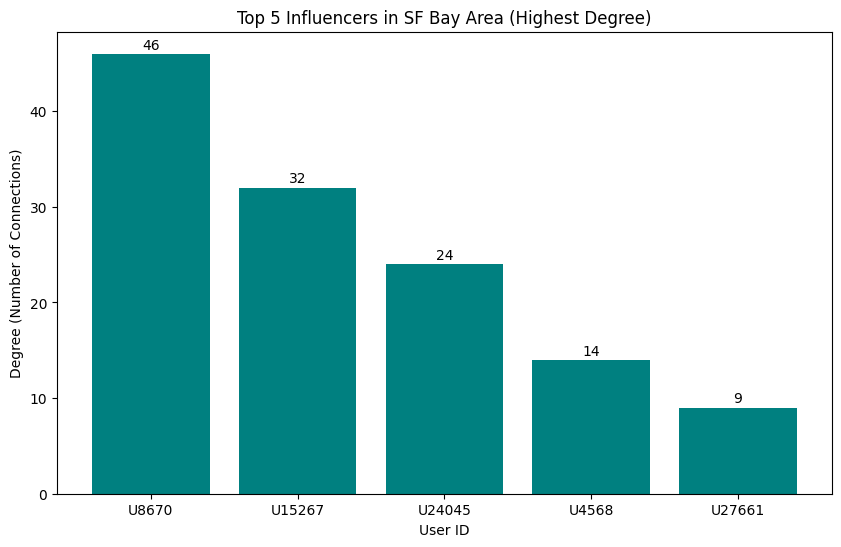

In [28]:
# Load data
df_loc = pd.read_csv("location.csv", sep="\t")
df_col = pd.read_csv("college.csv", sep="\t")
df_emp = pd.read_csv("employer.csv", sep="\t")

# Map degree to nodes
degree_dict = dict(G.degree())

# Filter for San Francisco Bay Area
sf_nodes = df_loc[df_loc['location'] == sf_area]['name'].unique()

# Calculate degrees for SF nodes
sf_degree_list = []
for node in sf_nodes:
    if node in degree_dict:
        sf_degree_list.append({'name': node, 'degree': degree_dict[node]})

df_sf_degree = pd.DataFrame(sf_degree_list)

# Get top 5
top_5_degree = df_sf_degree.sort_values(by='degree', ascending=False).head(5)

# Merge with college and employer for context
# Handling potential multiple entries by joining them
df_col_grouped = df_col.groupby('name')['college'].apply(lambda x: ', '.join(x)).reset_index()
df_emp_grouped = df_emp.groupby('name')['employer'].apply(lambda x: ', '.join(x)).reset_index()

top_5_context = top_5_degree.merge(df_col_grouped, on='name', how='left')
top_5_context = top_5_context.merge(df_emp_grouped, on='name', how='left')

print("Top 5 Influencers in SF Bay Area by Degree:")
print(top_5_context)

# Visualization
plt.figure(figsize=(10, 6))
top_5_sorted = top_5_context.sort_values(by='degree', ascending=True) # For horizontal or standard bar, sorted order is good.
plt.bar(top_5_context['name'], top_5_context['degree'], color='teal')
plt.title("Top 5 Influencers in SF Bay Area (Highest Degree)")
plt.ylabel("Degree (Number of Connections)")
plt.xlabel("User ID")
for i, v in enumerate(top_5_context['degree']):
    plt.text(i, v + 0.5, str(v), ha='center')
plt.savefig("top_5_degree_sf.png")

## Other different centrality metrics

In [29]:
profiles = df_loc.merge(df_col_grouped, on='name', how='left') \
                 .merge(df_emp_grouped, on='name', how='left')

In [30]:
# Calculate centrality metrics
pr = nx.pagerank(G)
bet = nx.betweenness_centrality(G)
deg = nx.degree_centrality(G)
eig = nx.eigenvector_centrality(G)

# Add metrics to the profile DataFrame
profiles['pagerank'] = profiles['name'].map(pr)
profiles['betweenness'] = profiles['name'].map(bet)
profiles['degree_centrality'] = profiles['name'].map(deg)
profiles['eigenvector'] = profiles['name'].map(eig)

### Degree centrality

       name  degree_centrality  \
771   U8670           0.056790   
429  U15267           0.039506   
521  U24045           0.029630   
669   U4568           0.017284   
126  U27661           0.011111   

                                               college  \
771  university of illinois at urbana-champaign, un...   
429  university of illinois at urbana-champaign, ba...   
521                                tsinghua university   
669                      shanghai jiao tong university   
126                      shanghai jiao tong university   

                                              employer  
771  akamai technologies, university of illinois at...  
429  university of illinois at urbana-champaign, ba...  
521    university of illinois at urbana-champaign, ibm  
669  google, university of illinois at urbana-champ...  
126  google, at&amp;t labs inc., university of mich...  


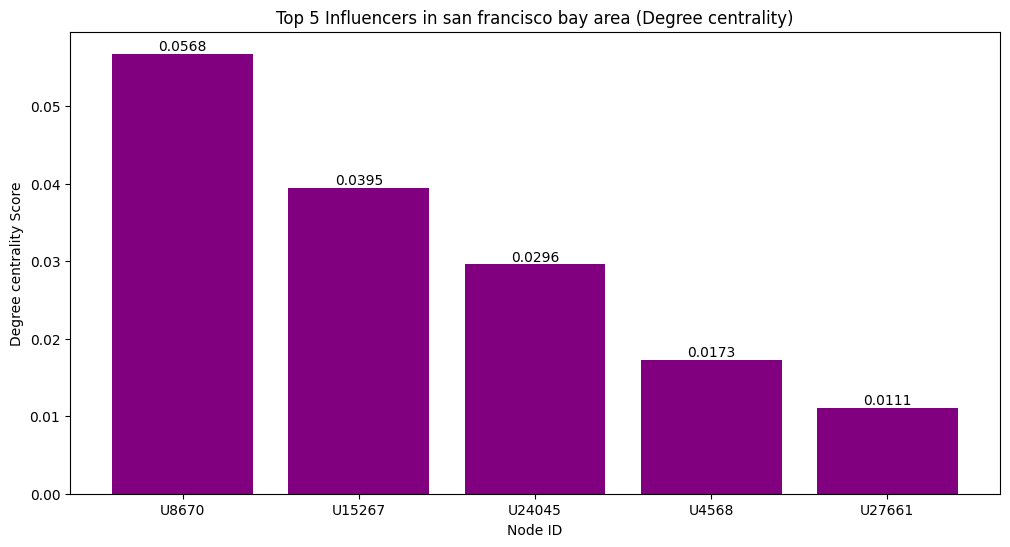

In [35]:
sf_influencers = profiles[profiles['location'] == sf_area].sort_values(by='degree_centrality', ascending=False)

# Display Top 5
top_5 = sf_influencers.head(5)
print(top_5[['name', 'degree_centrality', 'college', 'employer']])

# plot
plt.figure(figsize=(12, 6))
plt.bar(top_5['name'], top_5['degree_centrality'], color='purple')
plt.title(f"Top 5 Influencers in {sf_area} (Degree centrality)")
plt.ylabel("Degree centrality Score")
plt.xlabel("Node ID")
for i, val in enumerate(top_5['degree_centrality']):
    plt.text(i, val, f'{val:.4f}', ha='center', va='bottom')
plt.show()

### PageRank

       name  pagerank                                            college  \
771   U8670  0.013839  university of illinois at urbana-champaign, un...   
429  U15267  0.005244  university of illinois at urbana-champaign, ba...   
521  U24045  0.005037                                tsinghua university   
669   U4568  0.003241                      shanghai jiao tong university   
208  U16128  0.002353                                  peking university   

                                              employer  
771  akamai technologies, university of illinois at...  
429  university of illinois at urbana-champaign, ba...  
521    university of illinois at urbana-champaign, ibm  
669  google, university of illinois at urbana-champ...  
208  stanford university, total in china, guolairen...  


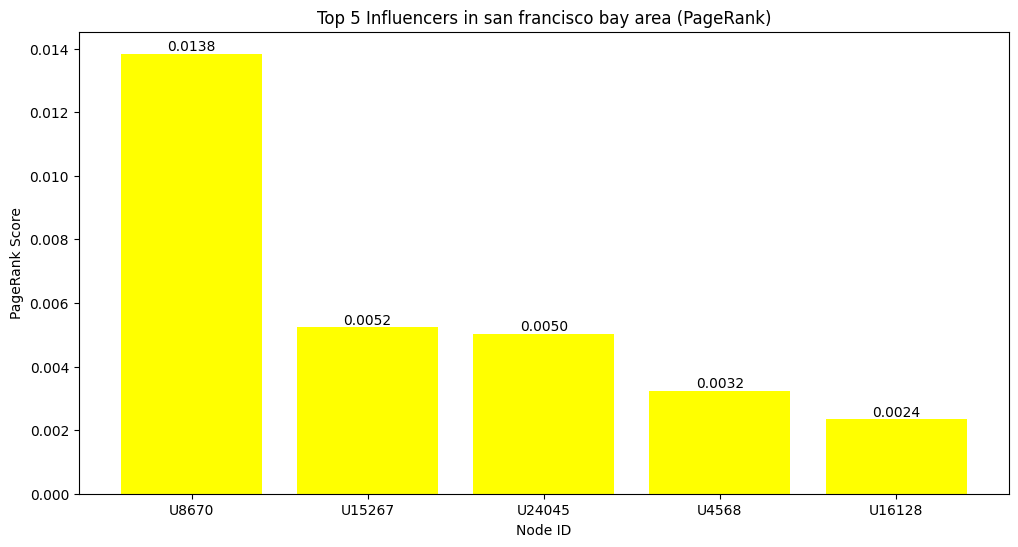

In [36]:
sf_influencers = profiles[profiles['location'] == sf_area].sort_values(by='pagerank', ascending=False)

# Display Top 5
top_5 = sf_influencers.head(5)
print(top_5[['name', 'pagerank', 'college', 'employer']])

# plot
plt.figure(figsize=(12, 6))
plt.bar(top_5['name'], top_5['pagerank'], color='yellow')
plt.title(f"Top 5 Influencers in {sf_area} (PageRank)")
plt.ylabel("PageRank Score")
plt.xlabel("Node ID")
for i, val in enumerate(top_5['pagerank']):
    plt.text(i, val, f'{val:.4f}', ha='center', va='bottom')
plt.show()

### Eigenvector centrality

       name  eigenvector                        college  \
521  U24045     0.220406            tsinghua university   
669   U4568     0.095345  shanghai jiao tong university   
126  U27661     0.082694  shanghai jiao tong university   
482  U24064     0.065668                            NaN   
802  U27613     0.063893                            NaN   

                                              employer  
521    university of illinois at urbana-champaign, ibm  
669  google, university of illinois at urbana-champ...  
126  google, at&amp;t labs inc., university of mich...  
482                                            twitter  
802                                           yelp.com  


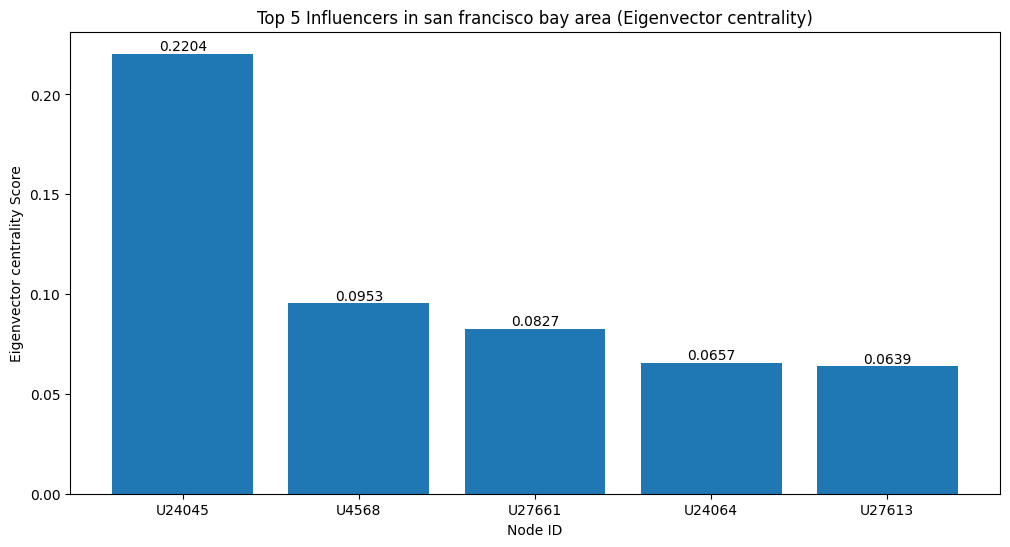

In [32]:
sf_influencers = profiles[profiles['location'] == sf_area].sort_values(by='eigenvector', ascending=False)

# Display Top 5
top_5 = sf_influencers.head(5)
print(top_5[['name', 'eigenvector', 'college', 'employer']])

# plot
plt.figure(figsize=(12, 6))
plt.bar(top_5['name'], top_5['eigenvector'])
plt.title(f"Top 5 Influencers in {sf_area} (Eigenvector centrality)")
plt.ylabel("Eigenvector centrality Score")
plt.xlabel("Node ID")
for i, val in enumerate(top_5['eigenvector']):
    plt.text(i, val, f'{val:.4f}', ha='center', va='bottom')
plt.show()

### Betweenness centrality

       name  betweenness                                            college  \
771   U8670     0.171799  university of illinois at urbana-champaign, un...   
669   U4568     0.126099                      shanghai jiao tong university   
401  U14577     0.107040                                  xiamen university   
723   U7202     0.091899                                                NaN   
429  U15267     0.051030  university of illinois at urbana-champaign, ba...   

                                              employer  
771  akamai technologies, university of illinois at...  
669  google, university of illinois at urbana-champ...  
401  stryker, zuzati inc. dba bidbass.com, internat...  
723  google, university of illinois at urbana-champ...  
429  university of illinois at urbana-champaign, ba...  


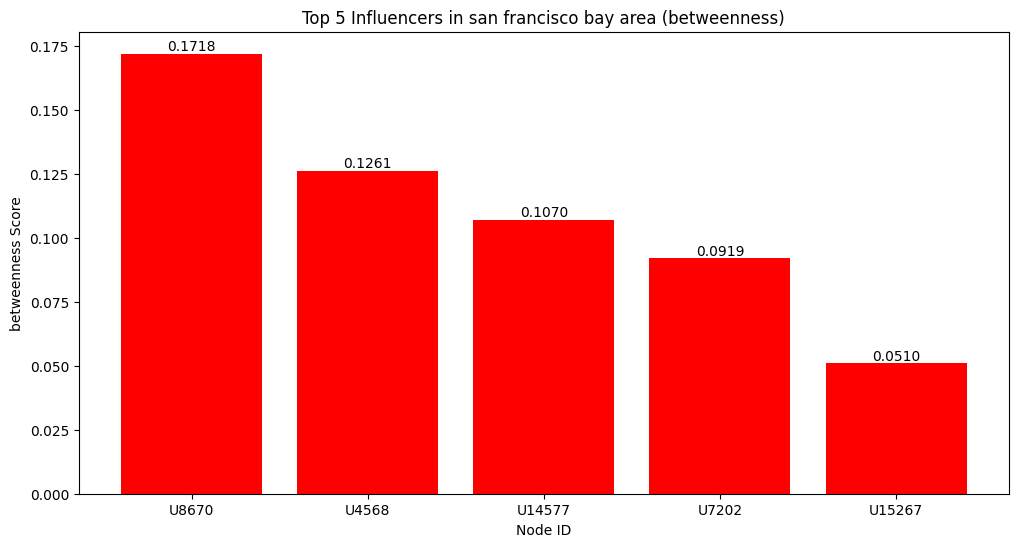

In [33]:
sf_influencers = profiles[profiles['location'] == sf_area].sort_values(by='betweenness', ascending=False)

# Display Top 5
top_5 = sf_influencers.head(5)
print(top_5[['name', 'betweenness', 'college', 'employer']])

# plot
plt.figure(figsize=(12, 6))
plt.bar(top_5['name'], top_5['betweenness'], color='red')
plt.title(f"Top 5 Influencers in {sf_area} (betweenness)")
plt.ylabel("betweenness Score")
plt.xlabel("Node ID")
for i, val in enumerate(top_5['betweenness']):
    plt.text(i, val, f'{val:.4f}', ha='center', va='bottom')
plt.show()